In [4]:
import pandas as pd
import numpy as np
import os

from scipy import io
import matplotlib.pyplot as plt
from sklearn import svm
import sys

import random
import sklearn.model_selection as skm
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from matplotlib.pyplot import subplots, cm
from ISLP import load_data, confusion_table
from ISLP.svm import plot as plot_svm

In [5]:
dir = '/Users/christian/Documents/GitHub/Machine Learning Projects/Support Vector Machine Optimization and Classification/data'
os.chdir(dir)
print(os.getcwd())
print(os.listdir())

/Users/christian/Documents/GitHub/Machine Learning Projects/Support Vector Machine Optimization and Classification/data
['toy-data.npz', 'spam', 'test', 'ham', 'submission.csv', 'kaggle_submission.txt', 'mnist-data.npz', 'Desktop\\MNIST.txt', 'spam-data.npz']


In [6]:
fields = "test_data", "training_data", "training_labels"

if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")


if __name__ == "__main__":
    for data_name in ["mnist", "spam", "toy"]:
        data = np.load(f"../data/{data_name}-data.npz")
        print("\nloaded %s data!" % data_name)
        for field in fields:
            print(field, data[field].shape)


loaded mnist data!
test_data (10000, 1, 28, 28)
training_data (60000, 1, 28, 28)
training_labels (60000,)

loaded spam data!
test_data (1000, 32)
training_data (4171, 32)
training_labels (4171,)

loaded toy data!
test_data (0,)
training_data (1000, 2)
training_labels (1000,)


# (2) Theory of Hard-Margin Support Vector Machines

### Import Toy Data

In [7]:
toy_data = np.load(f"../data/toy-data.npz")
X_train = toy_data['training_data']
Y_train = toy_data['training_labels']

### (2e) Plot Toy Data

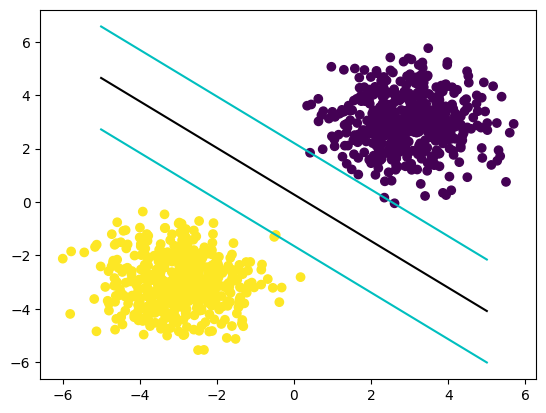

In [8]:
# Scatterplot of toy data
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train);

# Plot decision boundary
w = np.vstack(np.array([-0.4528, -0.5190]))
b = 0.1471
x = np.linspace(-5, 5, 100)
y = -(w[0] * x + b) / w[1]

# Define Margins
margin_1x = np.linspace(-5, 5, 100)
margin_1y = -((w[0] * x + b) - 1) / w[1]
margin_2x = np.linspace(-5, 5, 100)
margin_2y = -((w[0] * x + b) + 1) / w[1]

# Plot margins
plt.plot(margin_1x, margin_1y, 'c');
plt.plot(margin_2x, margin_2y, 'c');
plt.plot(x, y, 'k');

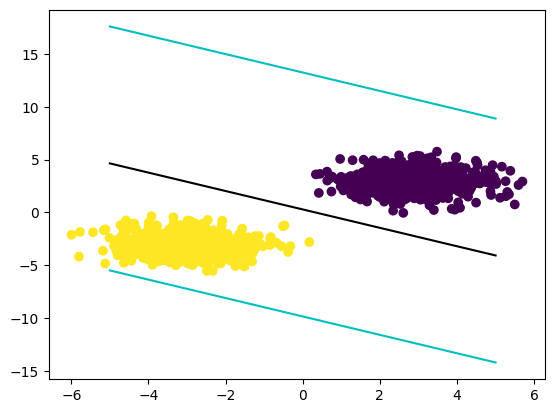

In [9]:
# Scatterplot of toy data
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train);

# Plot decision boundary
w = np.vstack(np.array([-0.4528, -0.5190]))
epsilon = 10
w_prime = w / (1 +(epsilon / 2) )
b = 0.1471
x = np.linspace(-5, 5, 100)
y = -(w[0] * x + b) / w[1]

# Define Margins
margin_1x = np.linspace(-5, 5, 100)
margin_1y = -((w_prime[0] * x + b) - 1) / w_prime[1]
margin_2x = np.linspace(-5, 5, 100)
margin_2y = -((w_prime[0] * x + b) + 1) / w_prime[1]

# Plot margins
plt.plot(margin_1x, margin_1y, 'c');
plt.plot(margin_2x, margin_2y, 'c');
plt.plot(x, y, 'k');

# Data Partitioning and Evaluation Metrics

### (3a) MNIST Data partitioning 

Note: We only need to use 'training_data', 'training_labels' for X_train, Y_train, X_test, and Y_test

Once we fit our models with these datasets, THEN we use 'test_data' to use as our submission to Kaggle. 

In [10]:
# Load MNIST data
mnist_data = np.load(f"../data/mnist-data.npz")

# Extract training data containing features
MNIST_features = mnist_data["training_data"]
MNIST_labels = mnist_data["training_labels"]

# Generate permutation indices from MNIST_training_data
indices = np.random.permutation(len(MNIST_features))

# Apply permutation to the training data and labels
MNIST_features_shuffled = MNIST_features[indices]
MNIST_labels_shuffled = MNIST_labels[indices]

# Define the training data
X_train_MNIST = MNIST_features_shuffled[10_000:]
Y_train_MNIST = MNIST_labels_shuffled[10_000:]

# Set aside 10,000 images from the training set as a validation set
X_test_MNIST = MNIST_features_shuffled[:10_000]
Y_test_MNIST = MNIST_labels_shuffled[:10_000]



### (3a) Spam Data Partitioning

In [11]:
# Load spam data
spam_data = np.load(f"../data/spam-data.npz")

# Extract the features and labels
spam_features = spam_data['training_data']
spam_labels = spam_data['training_labels']

# Generate permutation indices
indices = np.random.permutation(len(spam_features))

# Shuffle the the features and labels
spam_features_shuffled = spam_features[indices]
spam_labels_shuffled = spam_labels[indices]

# Define the index for 20th percentile
twenty_percentile_index_features = int(len(spam_features_shuffled) * 0.20)
twenty_percentile_index_labels = int(len(spam_labels_shuffled) * 0.20)

# Define the training data
X_train_spam = spam_features_shuffled[twenty_percentile_index_features:]
Y_train_spam = spam_labels_shuffled[twenty_percentile_index_labels:]

# Define the validation set as 20% of the data 
X_test_spam = spam_features_shuffled[:twenty_percentile_index_features]
Y_test_spam = spam_labels_shuffled[:twenty_percentile_index_labels]


### (3b) Evaluation Metric

In [12]:
def evaluation_metric(_y, _y_hat, sample_size):
    """Function returns classification accuracy"""
    correct_predictions = sum(_y_hat == _y)
    return (correct_predictions / sample_size)

# Support Vector Machines: Coding

### (4a) MNIST Model
* For images we will be using raw pixel brightness
* SVM linear model
* Use SKlearn to implement an SVM model; everything else must be done without the use of sklearn

In [13]:
MNIST_training_sizes = [100, 200, 500, 1_000, 2_000, 5_000, 10_000]
MNIST_accuracies = []

# Define models
MNIST_model = SVC(kernel='linear', random_state=42)

for size in MNIST_training_sizes:

    # Transform Y_train_MNIST
    Y_train_MNIST_flat = Y_train_MNIST[:size].reshape(Y_train_MNIST[:size].shape[0], -1)

    # Transform Y_test_MNIST
    Y_test_MNIST_flat = Y_test_MNIST[:size].reshape(Y_test_MNIST[:size].shape[0], -1)

    # Flatten Y_train_MNIST_flat
    Y_train_MNIST_flat = Y_train_MNIST_flat[:,0]

    # Flatten Y_test_MNIST_flat
    Y_test_MNIST_flat = Y_test_MNIST_flat[:,0]

    MNIST_model.fit(X_train_MNIST[:size].reshape(X_train_MNIST[:size].shape[0], -1), Y_train_MNIST_flat)

    y_hat = np.array(MNIST_model.predict(X_test_MNIST[:size].reshape(X_test_MNIST[:size].shape[0], -1)))
    
    MNIST_accuracies.append(evaluation_metric(Y_test_MNIST_flat,y_hat, len(y_hat)))

### (4a) MNIST Accuracy Plot

In [14]:
import plotly.express as px

MNIST_accuracies_df = pd.DataFrame({'Sample Size' : MNIST_training_sizes, 'Accuracy' : MNIST_accuracies})
fig = px.scatter(MNIST_accuracies_df, x = "Sample Size",y = "Accuracy", hover_data=['Accuracy'])
fig.update_layout(title='Scatter Plot of MNIST Sample Size vs Accuracy')
fig.show()

### (4b) Spam Dataset Model
* The training data for this dataset consists of word frequencies. For example if we have a vector of words ['one', 'two', 'three'], then given a tokenized email ['email', 'one', 'is', 'about', 'spam'], it would return: [1, 0, 0, 0, 0]


In [15]:
spam_sample_sizes = [100, 200, 500, 1_000, 2_000, len(X_train_spam)]
spam_accuracies = []

# Define model
spam_model = SVC(kernel='linear', random_state=42)

for i in spam_sample_sizes:
    spam_model.fit(X_train_spam[:i], Y_train_spam[:i])
    spam_y_hat = spam_model.predict(X_test_spam[:i])
    accuracy = evaluation_metric(Y_test_spam[:i], spam_y_hat, len(spam_y_hat))
    spam_accuracies.append(accuracy)
    

### (4b) Spam Accuracy Plot

In [16]:
spam_accuracies_df = pd.DataFrame({'Sample Size' : spam_sample_sizes, 'Accuracy' : spam_accuracies})

fig = px.scatter(spam_accuracies_df, x = "Sample Size",y = "Accuracy", hover_data=['Accuracy'])
fig.update_layout(title='Scatter Plot of Spam Sample Size vs Accuracy')
fig.show()


# (5) Hyperparameter Tuning
* When choosing a hyperparameter value, we train the model repeatedly with different hyperparameters. 
* We then select the hyperparameter that gives the model with the highest accuracy on the validation dataset. 
* Before generating predictions for the test set, the model should be retrained using all the labeled data (including the validation data) and the previously-determined hyperpa- rameter.

In [17]:
# Increase value of C to reduce training error, however this can lead to overfitting
MNIST_c_values = [0.0001, 0.001, 0.1, 10, 100, 1_000, 10_000, 100_000]
MNIST_accuracies_with_hyperparameter_tuning = []
sample_size = 20_000
MNIST_models = []

for c_value in MNIST_c_values:
    Y_train_MNIST_flat = Y_train_MNIST[:sample_size].reshape(
        Y_train_MNIST[:sample_size].shape[0], -1
        )
    # Transform Y_test_MNIST
    Y_test_MNIST_flat = Y_test_MNIST[:sample_size].reshape(
        Y_test_MNIST[:sample_size].shape[0], -1
        )
    # Flatten Y_train_MNIST_flat
    Y_train_MNIST_flat = Y_train_MNIST_flat[:,0]
    # Flatten Y_test_MNIST_flat
    Y_test_MNIST_flat = Y_test_MNIST_flat[:,0]
 
    # Define model
    MNIST_model = SVC(C = c_value, kernel='linear', random_state=42)
    # Fit the model
    MNIST_model.fit(X_train_MNIST[:sample_size].reshape(
        X_train_MNIST[:sample_size].shape[0], -1), 
        Y_train_MNIST_flat)
    # Make predictions
    y_hat_ = np.array(MNIST_model.predict(
        X_test_MNIST[:sample_size].reshape(
            X_test_MNIST[:sample_size].shape[0], -1)
            )
            )
    # Determine accuracy
    accuracy_c_with_cvals = evaluation_metric(Y_test_MNIST_flat, y_hat_, len(y_hat_))
    # Append current models accuracy to list of MNIST accuracies
    MNIST_accuracies_with_hyperparameter_tuning.append(accuracy_c_with_cvals)
    # Append the model to list of models
    MNIST_models.append(MNIST_model)


In [18]:
# Determine best MNIST model
top_MNIST_model = MNIST_models[MNIST_accuracies_with_hyperparameter_tuning.index(max(MNIST_accuracies_with_hyperparameter_tuning))]

# Determine best MNIST model's accuracy
top_MNIST_accuracy = max(MNIST_accuracies_with_hyperparameter_tuning)

# Determine optimal hyperparameter
top_MNIST_C_value  = MNIST_c_values[MNIST_accuracies_with_hyperparameter_tuning.index(max(MNIST_accuracies_with_hyperparameter_tuning))]

In [19]:
print(f"C values used: {MNIST_c_values}")
print(f"Corresponding Accuracies: {MNIST_accuracies_with_hyperparameter_tuning}")
print(f"Top C Value: {top_MNIST_C_value}")

C values used: [0.0001, 0.001, 0.1, 10, 100, 1000, 10000, 100000]
Corresponding Accuracies: [0.917, 0.9124, 0.9114, 0.9114, 0.9114, 0.9114, 0.9114, 0.9114]
Top C Value: 0.0001


### Hyperparameter Tuning Visualization

In [20]:
df_c_values_and_accuracy = pd.DataFrame({'C Value' : MNIST_c_values, 'MNIST Accuracy with Hyperparameter' : MNIST_accuracies_with_hyperparameter_tuning})
fig = px.scatter(df_c_values_and_accuracy, x = "C Value", y = "MNIST Accuracy with Hyperparameter", hover_data=['MNIST Accuracy with Hyperparameter'])
fig.update_layout(title='Scatter Plot of MNIST Sample Size vs Accuracy with Hyperparamter Tuning')
fig.show()


# (6) K-Fold Cross-Validation
* Recommended when sample size is relatively small i.e. spam dataset.
* **Training data** is shuffled and partitioned into **k disjoint sets**.
* Model is trained on **k-1** sets, and validated on the **kth** set.
* Process is repeated **k** times with **each set** chosen as the validation set once.
* **Cross-validation** accuracy is the accuracy averaged over k iterations.

- **Delivarable**
    * Spam dataset, used k = 5 cross-validation to find best *C* value.
    * List C values used, corresponding accuracies, and best *C* value.



In [21]:
# c values to test
spam_c_values = [0.001, 0.01, 0.1, 100, 500, 900, 1500, 1800]

# Determine size of dataset
training_size = len(X_train_spam)

# Variables to hold models 
spam_models = []
spam_model_mean_accuracy = []

# number of folds
K = 5

# shuffle spam dataset training features (X_train)
shuffled_indexes = np.random.permutation(len(X_train_spam))
X_train_spam_shuffled = X_train_spam[shuffled_indexes]

# shuffle spam dataset training labels (Y_train)
Y_train_spam_shuffled = Y_train_spam[shuffled_indexes]

# determine splits into k - 1 disjoint sets
folds = np.array_split(np.arange(training_size), K)


In [22]:
# Iterate through each hyperparameter value
for c_val in spam_c_values:
    k_fold_accuracy= []
    # Iterate through each fold K 
    for i in range(K):
        
        # Define model
        model = SVC(C=c_val, kernel='linear', random_state=42)
        test_indices = folds[i]
        train_indices = np.concatenate([fold for j, fold in enumerate(folds) if j != i])

        X_train = X_train_spam_shuffled[train_indices]
        Y_train = Y_train_spam_shuffled[train_indices]
        X_test = X_train_spam_shuffled[test_indices]
        Y_test = Y_train_spam_shuffled[test_indices]
        
        # Fit the model on the training sets
        model.fit(X_train, Y_train)
            
        # Predict X_test
        y_hat = model.predict(X_test)

        # calculate the accuracy of the model with the current fold and C value
        accuracy = evaluation_metric(Y_test, y_hat, len(y_hat))

        # append the accuracy to a list of accuracies
        k_fold_accuracy.append(accuracy)

    spam_models.append(model) 
    # after all folds have been tested, get the mean accuracy for each k
    spam_model_mean_accuracy.append(np.mean(k_fold_accuracy))
    


In [23]:
# Determine best model
top_spam_model = spam_models[spam_model_mean_accuracy.index(max(spam_model_mean_accuracy))]

# Determine best model's accuracy
top_spam_accuracy = max(spam_model_mean_accuracy)

# Determine optimal hyperparameter for SPAM model
top_spam_C_value = spam_c_values[spam_model_mean_accuracy.index(max(spam_model_mean_accuracy))]

In [24]:
print(f"C values used: {spam_c_values}")
print(f"Corresponding Accuracies: {spam_model_mean_accuracy}")
print(f"Top C Value: {top_spam_C_value}")

C values used: [0.001, 0.01, 0.1, 100, 500, 900, 1500, 1800]
Corresponding Accuracies: [0.7425894837012631, 0.767460880338274, 0.790530932138721, 0.7974220973345663, 0.7989200010773057, 0.7992194022749104, 0.79981820467012, 0.7989200010773057]
Top C Value: 1500


# Kaggle


In [25]:
# Usage: results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('/Users/christian/Desktop/submission.csv', index_label='Id')


### MNIST Kaggle Predictions

In [26]:
# Load the MNIST test data
MNIST_test_data = mnist_data['test_data']
# Make predictions using best MNIST model
kaggle_y_hat = top_MNIST_model.predict(MNIST_test_data.reshape(X_test_MNIST[:len(MNIST_test_data)].shape[0], -1))
# Export MNIST predictions to csv
results_to_csv(kaggle_y_hat)

### Spam Kaggle Predictions

In [27]:
# Load spam test data
spam_test_data = spam_data['test_data']
# Make predictions using best spam models
spam_y_hat = top_spam_model.predict(spam_test_data)
# Export spam predictions to CSV
results_to_csv(spam_y_hat)